In [1]:
import math

import random
import numpy as np
import torch
from torch import nn
import torchvision.utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity

from modules.dataset import LoadMRI, DatasetReconMRI
from modules.dataset import build_loaders
from modules.utils import kspace2image, image2kspace, complex2pseudo, pseudo2real, pseudo2complex, imsshow
from modules.solver import Solver, Lab1Solver

In [ ]:
%load_ext autoreload
%autoreload 2

# Preprocess

In [2]:
dataset = LoadMRI('./cine.npz')
CINE_INDEX = random.randint(0, 199)

In [3]:
data_test = DatasetReconMRI(dataset)

img_und: (20, 192, 192), und_mask: (20, 192, 192), img_gt: (20, 192, 192)
img_und: float32, und_mask: float32, img_gt: float32


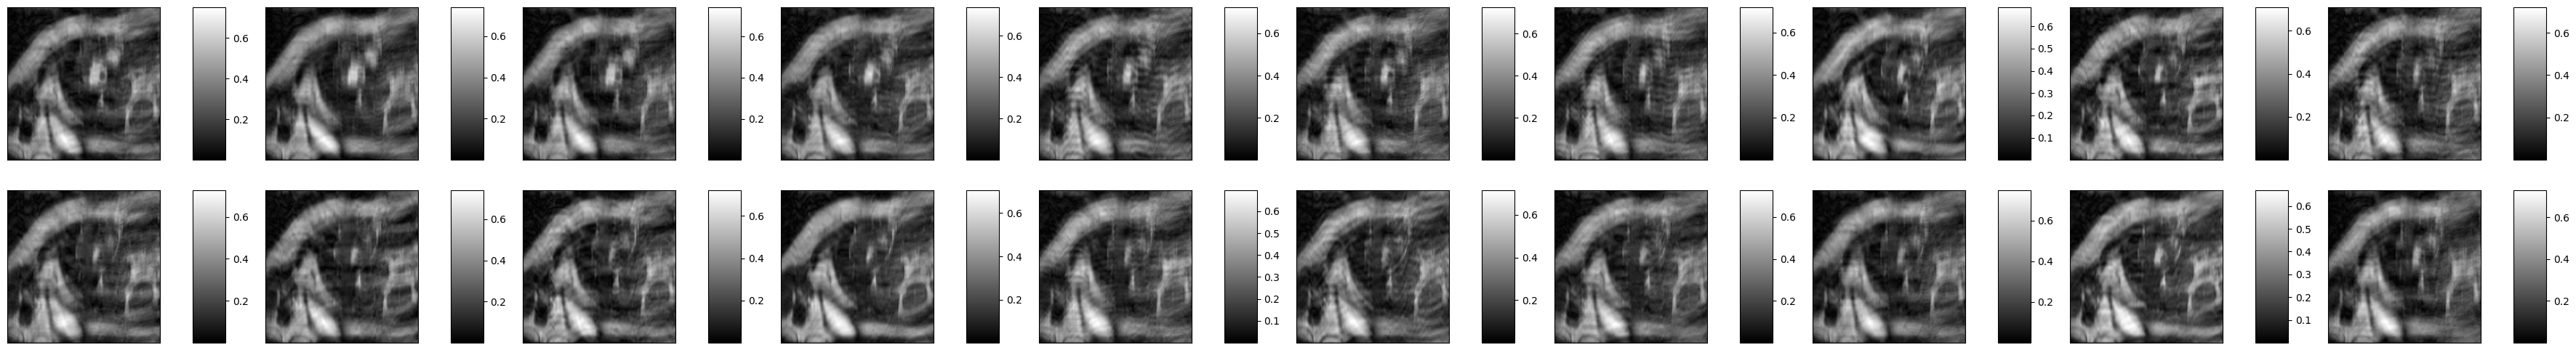

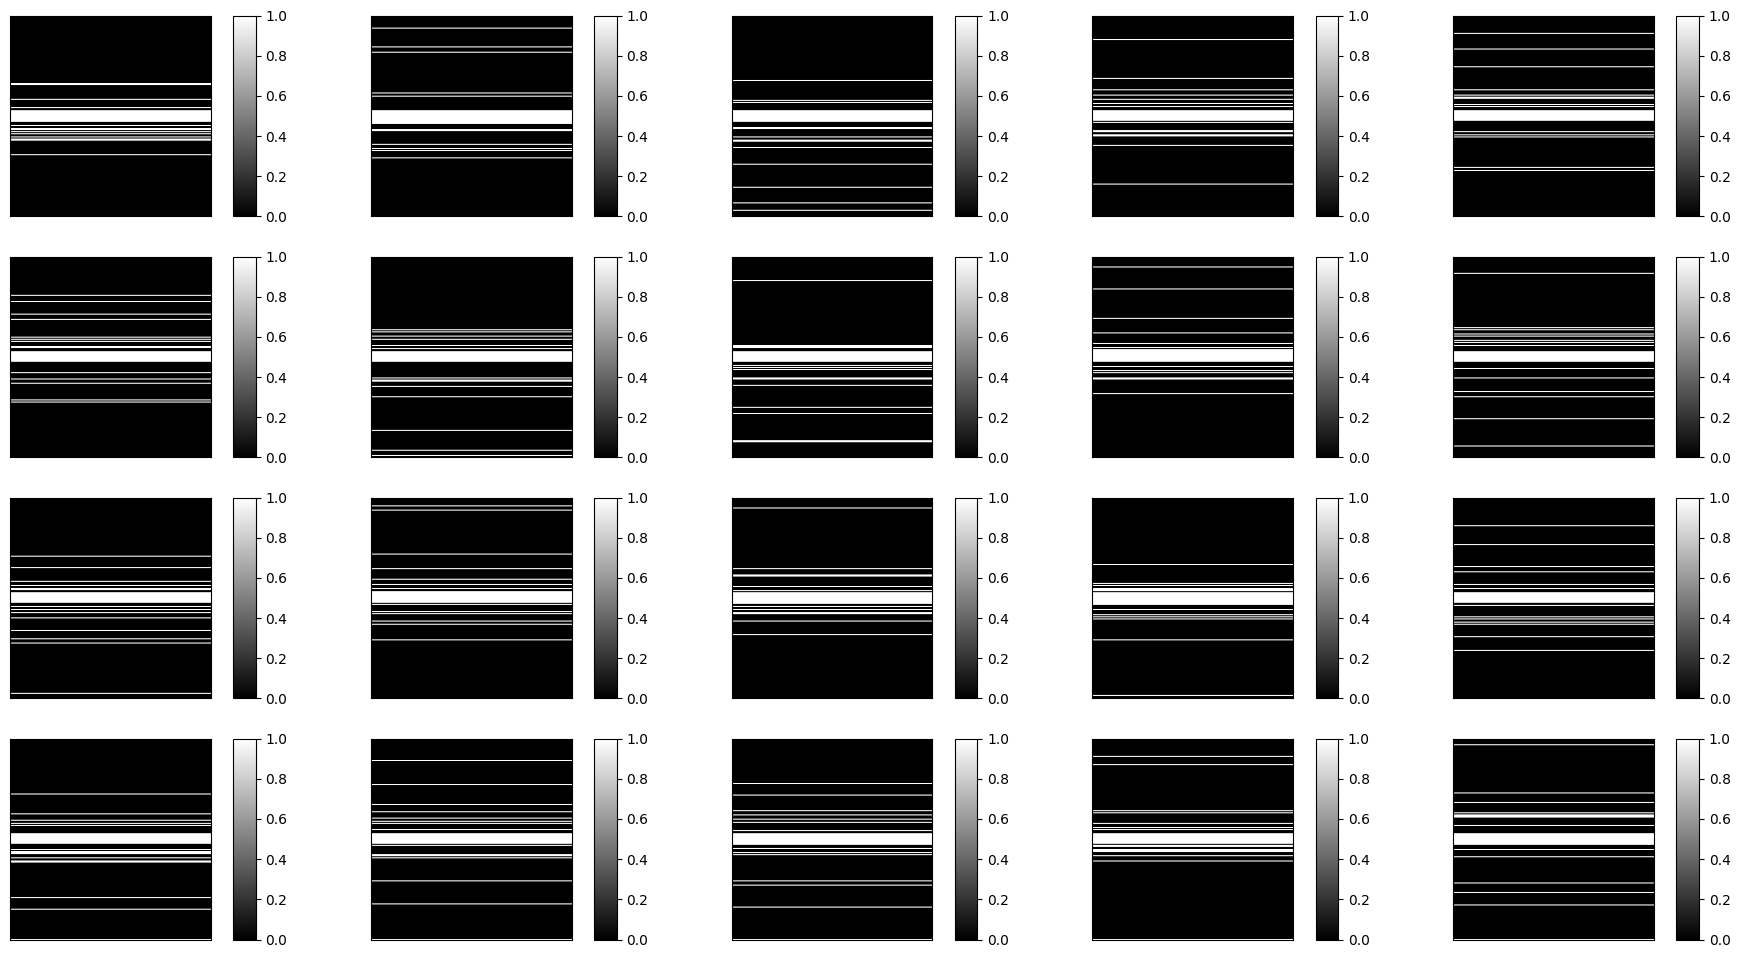

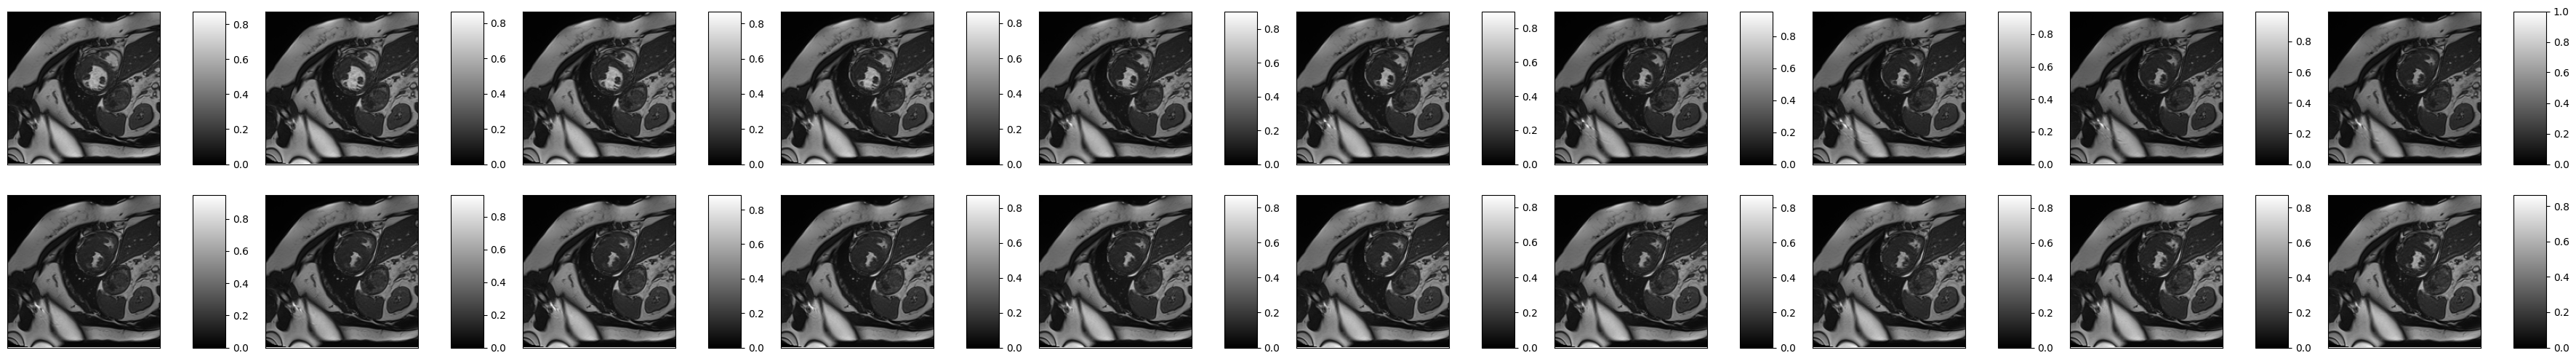

In [4]:
img_und, und_mask, img_gt = data_test[CINE_INDEX]
print(f"img_und: {img_und.shape}, und_mask: {und_mask.shape}, img_gt: {img_gt.shape}")
print(f"img_und: {img_und.dtype}, und_mask: {und_mask.dtype}, img_gt: {img_gt.dtype}")

# Try different index range in [0, 1000) to see different images in dataset.
imsshow(img_und, num_col=10, cmap='gray', is_colorbar=True)
imsshow(und_mask, num_col=5, cmap='gray', is_colorbar=True)
imsshow(img_gt, num_col=10, cmap='gray', is_colorbar=True)

In [5]:
TRAIN_INDICES = np.arange(0, 112)
VAL_INDICES = np.arange(112, 140)
TEST_INDICES = np.arange(140, 200)

train_loader, val_loader, test_loader = build_loaders(
    dataset, TRAIN_INDICES, VAL_INDICES, TEST_INDICES,
    batch_size=5  # Reduce this number if your computer does not has large gpu vram
)
print(f"Number of batches for train/val/test: {len(train_loader)}/{len(val_loader)}/{len(test_loader)}")

Number of batches for train/val/test: 23/6/12


In [6]:
train_loader

# Network

## from chatGPT

```python
device = torch.device('cuda')

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 3 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(-1, 128 * 3 * 3 * 3)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        
        return x
# 实例化一个CNN3D对象
net = CNN3D()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# 准备数据并进行训练
for epoch in range(23):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        data.shape
        inputs, labels = data
        inputs = inputs.unsqueeze(1)  # 将数据的通道数变成1
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print('Epoch %d loss: %.3f' % (epoch+1, running_loss/len(train_loader)))

```

## test

In [7]:
class MRIReconstructionFramework(nn.Module):
    def __init__(self, recon_net: nn.Module):
        super().__init__()
        self.recon_net = recon_net

    def forward(self, k_und, mask):
        B, C, H, W = k_und.shape
        im_und = k_und
        im_recon = self.recon_net(im_und)
        return im_recon

In [8]:
# Network definition
class MultiLayerCNN(nn.Module):
    def __init__(self, n_hidden=64):
        super().__init__()
        self.conv1 = nn.Conv2d(20, n_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(n_hidden, n_hidden, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(n_hidden, 20, kernel_size=3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, im_und):
        """
        - im_und: tensor[B, C=20, H, W]
        """
        x = self.relu(self.conv1(im_und))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        diff = self.conv5(x)
        im_recon = diff + im_und
        return im_recon


# test a forward
im_mock = torch.randn(20, 192, 192)
net = MultiLayerCNN()
out = net(im_mock)
print(out.shape)


torch.Size([20, 192, 192])


In [9]:
class MSELoss():
    def __call__(self, im_recon, im_gt):
        """
        - im_recon: tensor[B, C=2, H, W]
        - im_gt: tensor[B, C=2, H, W]
        """
        B, C, H, W = im_recon.shape
        x = pseudo2real(im_recon)  # [B, H, W]
        y = pseudo2real(im_gt)     # [B, H, W]
        loss = torch.mean((y - x) ** 2) * B
        return loss


# test for loss computation
mse = MSELoss()
x_mock = torch.randn(20, 192, 192)

  0%|          | 0/112 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/28 [00:00<?, ?img/s]

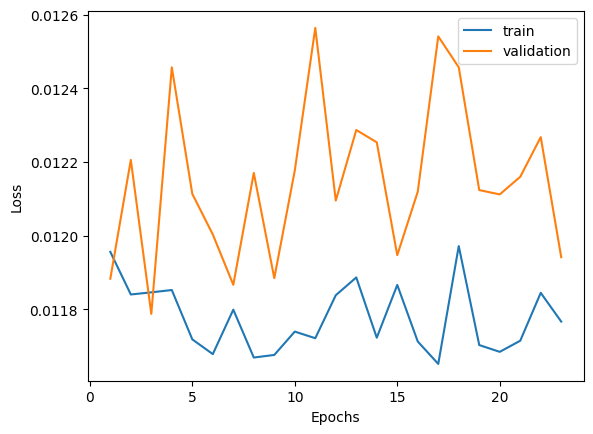

[Validation]:   0%|          | 0/60 [00:00<?, ?img/s]

ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

In [10]:
# Define network
net = MRIReconstructionFramework(
    recon_net=MultiLayerCNN()
)

optimizer=torch.optim.Adam(
        net.parameters(),
        lr=0.0001
    )
# Training & Validation
solver = Solver(
    model=net,
    optimizer=optimizer,
    criterion=MSELoss(),
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
)

epochs_to_train = 23
solver.train(epochs_to_train, train_loader, val_loader=val_loader)
solver.validate(test_loader)

In [12]:
# changing data_index to see diffferent sample's visualization
data_index = 30 # range in [0, 200)
solver.visualize(test_loader, data_index, dpi=100)

torch.Size([5, 20, 192, 192])
torch.Size([5, 192, 192])
torch.Size([5, 192, 192])


AssertionError: target_im and reconstructed_im is not compatible to compute PSNR metric